### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ipywidgets as widgets

import os
from random import shuffle
from PIL import Image
import h5py

import seaborn as sns
sns.set(style="ticks")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, SubsetRandomSampler

### Parameters

In [3]:
# MEDICAL_DATA = '/pio/lscratch/1/i279076/Medical/medical.h5'
# OUTPUT = '/pio/lscratch/1/i279076/Medical/small-medical-{}.h5'

MEDICAL_DATA = '/home/ath0m/Desktop/medical.h5'
OUTPUT = '/home/ath0m/Desktop/small-medical-{}.h5'

BATCH_SIZE = 1024

### Dataset

In [4]:
class MedicalDataset(Dataset):
    def __init__(self, images, masks, patch_size=32):
        self.images = images
        self.masks = masks
        
        self.patch_size = patch_size
        
        self.images_count, self.image_size, _, _ = self.images.shape
        self.patches_per_side = self.image_size - self.patch_size + 1
        self.patches_per_image = self.patches_per_side ** 2
    
    def __len__(self):
        return self.images_count * self.patches_per_image
    
    def __getitem__(self, idx):
        image_idx = idx // self.patches_per_image
        patch_idx = idx % self.patches_per_image
        
        image = self.images[image_idx]
        mask = self.masks[image_idx]
        
        y = patch_idx // self.patches_per_side
        x = patch_idx % self.patches_per_side
        
        patch = image[y: y + self.patch_size, x: x + self.patch_size].transpose(2, 0, 1) / 255.
        label = mask.item((y + self.patch_size // 2, x + self.patch_size // 2, 0)) // 255
        
        return (patch, label)

### Dataset statistics

In [5]:
patch_size = 22
dataset = 'train'
batch_size = 2**12

In [6]:
with h5py.File(MEDICAL_DATA, 'r') as f:
        images = f[dataset]['images'][...]
        masks = f[dataset]['masks'][...]

dataset = MedicalDataset(images, masks, patch_size=patch_size)

In [ ]:
loader = DataLoader(dataset, batch_size=2**14, num_workers=8)

negative_data_sums = []
positive_data_sums = []

for i, (data, labels) in enumerate(loader):
    batch_sum = data.reshape(data.shape[0], -1).sum(1).data.numpy()
    
    positive_batch_sum = batch_sum[labels.nonzero().numpy()].ravel()
    negative_batch_sum = batch_sum[(labels == 0).nonzero().numpy()].ravel()

    positive_data_sums.extend([v.item() for v in positive_batch_sum])
    negative_data_sums.extend([v.item() for v in negative_batch_sum])

    if i % 500 == 0: print('[{:.3f}%]'.format(100. * i / len(loader)))

In [8]:
negative_data_sums = np.load('/home/ath0m/Desktop/Medical/negative.npz.npy')
positive_data_sums = np.load('/home/ath0m/Desktop/Medical/positive.npz.npy')

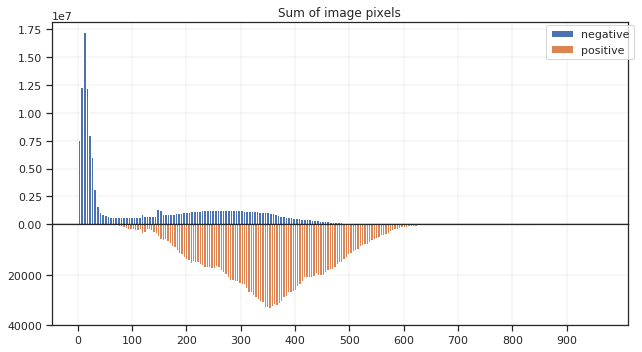

In [10]:
gs = GridSpec(3, 1)

fig = plt.figure(figsize=(9, 5))

ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax1.hist(negative_data_sums, bins=200, label='negative')
ax1.grid(True, lw=0.3)

ax2.hist(positive_data_sums, color='#DD8452', bins=200, label='positive')
ax2.grid(True, lw=0.3)

ax1.set_xticks(range(0, 1000, 100))
ax2.invert_yaxis()

ax2.set_yticks(ax2.get_yticks()[1:])

ax1.set_title('Sum of image pixels')

fig.legend(loc=(0.85, 0.83))
fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

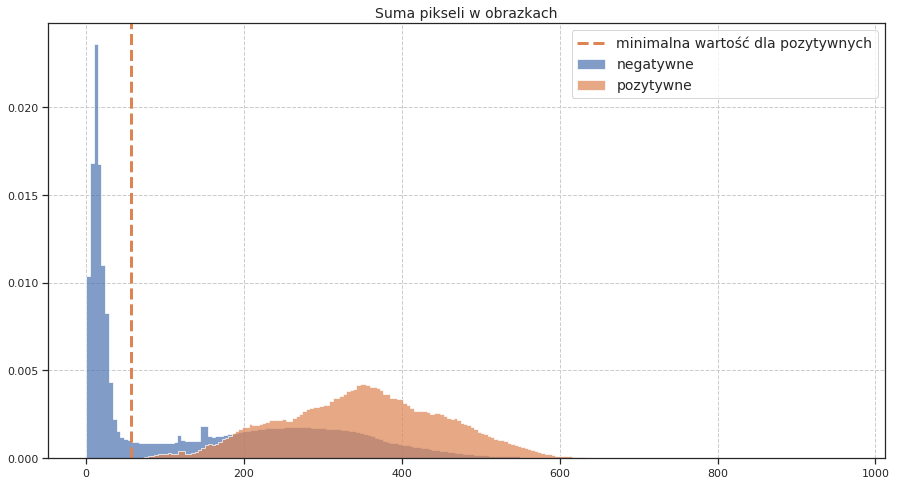

In [29]:
plt.figure(figsize=(15, 8))

plt.hist(negative_data_sums, bins=200, label='negatywne', density=True, alpha=0.7, histtype='stepfilled')
plt.hist(positive_data_sums, bins=200, label='pozytywne', density=True, alpha=0.7, histtype='stepfilled')

plt.axvline(min(positive_data_sums), ls='--', lw=3., color='#DD8452', label='minimalna wartość dla pozytywnych')

plt.grid(True, ls='--')
plt.legend(fontsize=14)
plt.title('Suma pikseli w obrazkach', fontsize=14)

plt.show()

In [8]:
min(positive_data_sums)

56.5019607843137

In [12]:
(np.array(negative_data_sums) < 42).sum() / len(negative_data_sums)

0.45547378478948297